# Einfaches neuronales Netzwerk "Zu Fuß"

Aufgabe: Implementierung eines Netzwerks, welches den Datensatz eines Polymoms 'lernt'.

$$
f(x) = \frac{1}{2}x^3 - 2x^2 + x
$$

Im Wertebereich $x \in [-2.5; 2.5]$.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Definition der / des 'wahren' Funktion / Modells.

In [6]:
def true_fun(x):
    return 0.5*x**3 - 2.0*x**2 + 1.0*x

Erzeugung von Datenpunkten anhand des wahren Modells, mit Rauschen (im Wertebereich).

In [7]:
rng = np.random.default_rng(0)
N = 300
X = rng.uniform(-2.5, 2.5, size=(N, 1))
Y = true_fun(X) + rng.normal(0, 0.8, size=(N, 1))

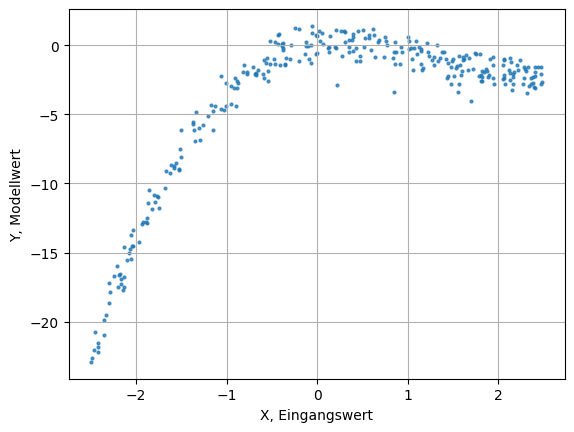

In [10]:
plt.scatter(X, Y, s=4, alpha=0.75)
plt.xlabel("X, Eingangswert")
plt.ylabel("Y, Modellwert")
plt.grid()

Aufteilung in Trainings und Test Daten. Normierung der Werte.

In [15]:
# Train/Test-Split
perm = rng.permutation(N)
split = int(0.8 * N)
Xtr, Ytr = X[perm[:split]], Y[perm[:split]]
Xte, Yte = X[perm[split:]], Y[perm[split:]]

# Standardisierung (stabilisiert Training deutlich)
x_mean = Xtr.mean(axis=0, keepdims=True)
x_std  = Xtr.std(axis=0, keepdims=True) + 1e-8
y_mean = Ytr.mean(axis=0, keepdims=True)
y_std  = Ytr.std(axis=0, keepdims=True) + 1e-8

Xs_tr = (Xtr - x_mean) / x_std
Xs_te = (Xte - x_mean) / x_std
Ys_tr = (Ytr - y_mean) / y_std
Ys_te = (Yte - y_mean) / y_std

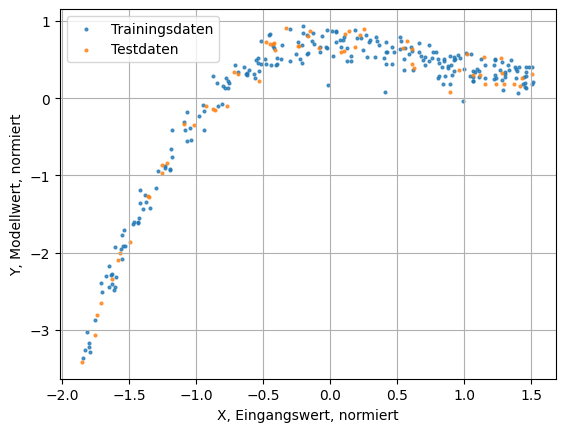

In [17]:
plt.scatter(Xs_tr, Ys_tr, s=4, alpha=0.75, label="Trainingsdaten")
plt.scatter(Xs_te, Ys_te, s=4, alpha=0.75, label="Testdaten")
plt.xlabel("X, Eingangswert, normiert")
plt.ylabel("Y, Modellwert, normiert")
plt.legend()
plt.grid()

Hilfsfunktionen. ToDo: Erläutern + plotten.

In [18]:
def tanh(z): 
    return np.tanh(z)

def dtanh(z):
    t = np.tanh(z)
    return 1.0 - t*t

def mse(yhat, y):
    return ((yhat - y) ** 2).mean()

def mse_grad(yhat, y):
    return 2.0 * (yhat - y) / y.shape[0]

Eine NN-Klasse um ein neuronales Netzwerk (Eingangslayer, 2 versteckte Layer, Ausgabelayer) zu definieren.

In [19]:
class NN:
    def __init__(self, in_dim=1, h1=20, h2=20, seed=1):
        rng = np.random.default_rng(seed)
        # Glorot-Normal (gut für tanh)
        def glorot(fan_in, fan_out):
            std = np.sqrt(2.0 / (fan_in + fan_out))
            return rng.normal(0.0, std, size=(fan_in, fan_out))

        self.W1 = glorot(in_dim, h1); self.b1 = np.zeros((1, h1))
        self.W2 = glorot(h1, h2);     self.b2 = np.zeros((1, h2))
        self.W3 = glorot(h2, 1);      self.b3 = np.zeros((1, 1))

    # Netzwerk forwärts durchlaufen
    def forward(self, X):
        z1 = X @ self.W1 + self.b1
        a1 = tanh(z1)
        z2 = a1 @ self.W2 + self.b2
        a2 = tanh(z2)
        yhat = a2 @ self.W3 + self.b3
        cache = (X, z1, a1, z2, a2, yhat)
        return yhat, cache

    # Netzwerk rückwärts durchlaufen (fürs Training)
    def backward(self, cache, yhat, y, l2=0.0):
        X, z1, a1, z2, a2, _ = cache

        dy = mse_grad(yhat, y)

        # Layer 3
        dW3 = a2.T @ dy
        db3 = dy.sum(axis=0, keepdims=True)

        # Layer 2
        da2 = dy @ self.W3.T
        dz2 = da2 * dtanh(z2)
        dW2 = a1.T @ dz2
        db2 = dz2.sum(axis=0, keepdims=True)

        # Layer 1
        da1 = dz2 @ self.W2.T
        dz1 = da1 * dtanh(z1)
        dW1 = X.T @ dz1
        db1 = dz1.sum(axis=0, keepdims=True)

        # L2 (optional) auf Gewichte
        if l2 > 0.0:
            dW3 += l2 * self.W3
            dW2 += l2 * self.W2
            dW1 += l2 * self.W1

        grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2, "W3": dW3, "b3": db3}
        return grads

    # Update der Gewichte anhand eines Gradienten und einer Lernrate
    def step(self, grads, lr):
        self.W1 -= lr * grads["W1"]; self.b1 -= lr * grads["b1"]
        self.W2 -= lr * grads["W2"]; self.b2 -= lr * grads["b2"]
        self.W3 -= lr * grads["W3"]; self.b3 -= lr * grads["b3"]

ToDo: einfache Visualisierung des Netzwerks möglich? Ggf. was von ChatGPT programmieren lassen 😁

Training des Netzes.

In [21]:
model = NN(in_dim=1, h1=20, h2=20, seed=1)
epochs = 800
lr = 0.03
batch = 64
l2 = 0.0  # z.B. 1e-4 für leichte Glättung

train_hist = []
test_hist = []

for ep in range(1, epochs + 1):
    idx = rng.permutation(len(Xs_tr))
    for i in range(0, len(idx), batch):
        b = idx[i:i+batch]
        xb, yb = Xs_tr[b], Ys_tr[b]

        yhat, cache = model.forward(xb)
        grads = model.backward(cache, yhat, yb, l2=l2)
        model.step(grads, lr)

    # Tracking (auf skalierten Größen)
    yhat_tr, _ = model.forward(Xs_tr)
    yhat_te, _ = model.forward(Xs_te)
    train_hist.append(mse(yhat_tr, Ys_tr))
    test_hist.append(mse(yhat_te, Ys_te))

    if ep % 100 == 0 or ep == 1:
        print(f"Epoch {ep:3d} | MSE train {train_hist[-1]:.4f} | MSE test {test_hist[-1]:.4f}")


Epoch   1 | MSE train 0.6644 | MSE test 0.8430
Epoch 100 | MSE train 0.0541 | MSE test 0.0768
Epoch 200 | MSE train 0.0291 | MSE test 0.0361
Epoch 300 | MSE train 0.0250 | MSE test 0.0289
Epoch 400 | MSE train 0.0232 | MSE test 0.0248
Epoch 500 | MSE train 0.0218 | MSE test 0.0234
Epoch 600 | MSE train 0.0213 | MSE test 0.0222
Epoch 700 | MSE train 0.0210 | MSE test 0.0208
Epoch 800 | MSE train 0.0207 | MSE test 0.0208


In [22]:
# Denormierte Vorhersagen auf Test
yhat_te_dn = yhat_te * y_std + y_mean
mse_test_dn = mse(yhat_te_dn, Yte)
ss_res = float(((yhat_te_dn - Yte) ** 2).sum())
ss_tot = float(((Yte - Yte.mean()) ** 2).sum())
r2 = 1.0 - ss_res / ss_tot
print(f"Denormierte Test-MSE: {mse_test_dn:.4f} | R^2: {r2:.3f}")

Denormierte Test-MSE: 0.6466 | R^2: 0.983


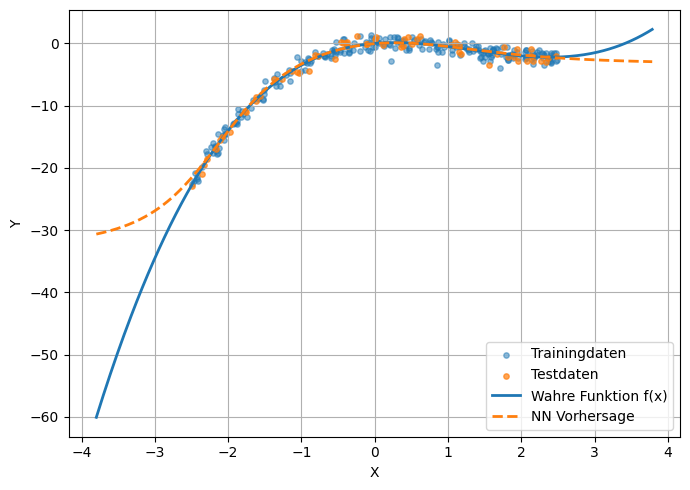

In [25]:
# Fit-Kurve gegen wahres Modell und Datenpunkte
xgrid = np.linspace(X.min()-1.3, X.max()+1.3, 400, dtype=np.float32).reshape(-1, 1)
xgrid_s = (xgrid - x_mean) / x_std
ygrid_s, _ = model.forward(xgrid_s)
ygrid = ygrid_s * y_std + y_mean

plt.figure(figsize=(7, 5))
plt.scatter(Xtr, Ytr, s=15, alpha=0.5, label="Trainingdaten")
plt.scatter(Xte, Yte, s=15, alpha=0.7, label="Testdaten")
plt.plot(xgrid, true_fun(xgrid), linewidth=2, label="Wahre Funktion f(x)")
plt.plot(xgrid, ygrid, linewidth=2, linestyle="--", label="NN Vorhersage")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid()
plt.tight_layout()

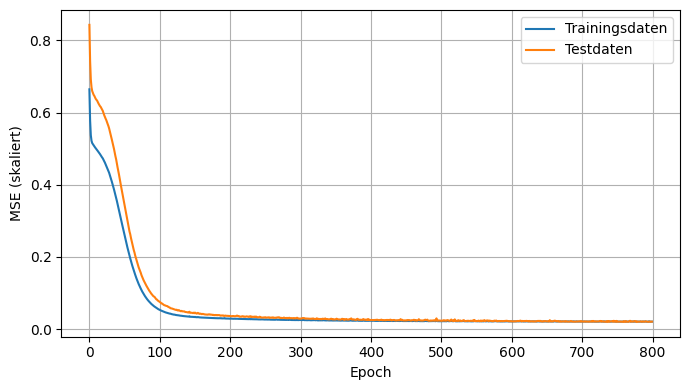

In [26]:
# Lernkurven (MSE auf skalierten Targets)
plt.figure(figsize=(7, 4))
plt.plot(train_hist, label="Trainingsdaten")
plt.plot(test_hist, label="Testdaten")
plt.xlabel("Epoch")
plt.ylabel("MSE (skaliert)")
plt.legend()
plt.tight_layout()
plt.grid()

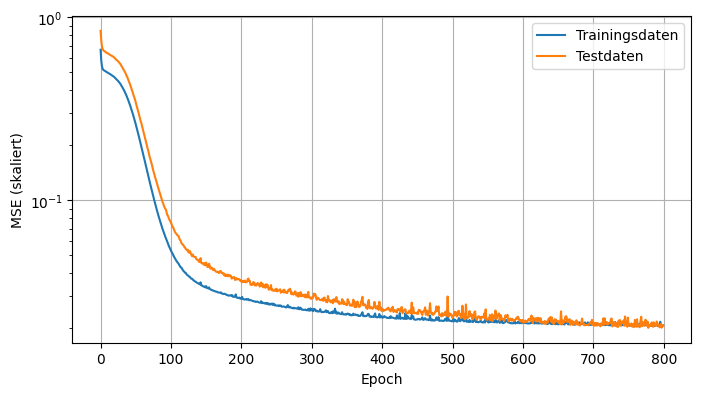

In [27]:
# Lernkurven (MSE auf skalierten Targets)
plt.figure(figsize=(7, 4))
plt.plot(train_hist, label="Trainingsdaten")
plt.plot(test_hist, label="Testdaten")
plt.xlabel("Epoch")
plt.ylabel("MSE (skaliert)")
plt.legend()
plt.tight_layout()
plt.grid()
plt.yscale('log')